#  Muon Differential Cross-Sections
#### Roland Grinis  -  Researcher at MIPT Nuclear Physics Methods lab  -  CTO at GrinisRIT (grinisrit.com)
#### Danila Riazanov - Student at MIPT,  JetBrains Research trainee

Code available within `NOA` [github.com/grinisrit/noa](https://github.com/grinisrit/noa) - Differentiable Programming Algorithms in `C++17` over [LibTorch](https://pytorch.org/cppdocs)

## Installation

The `conda` environment provided with the repository has all the required dependencies. For this particular tutorial we will need the following `python` packages:

In [4]:
import torch
from torch.utils.cpp_extension import load
import matplotlib.pyplot as plt

Now we need to build and load `C++17/CUDA` extensions for `PyTorch`, set up the locations:

In [5]:
!mkdir -p build
noa_location = '../..'

If you are running this on Google Colab, you need to clone `NOA` and set `noa_location` accordingly:
```python
!git clone https://github.com/grinisrit/noa.git
noa_location = 'noa'
```

Also, make sure that `ninja` and `g++-9` or higher are available. The following commands will do that for you:
```python
!pip install Ninja
!add-apt-repository ppa:ubuntu-toolchain-r/test -y
!apt update
!apt upgrade -y
!apt install gcc-9 g++-9
!update-alternatives --install /usr/bin/gcc gcc /usr/bin/gcc-9 100 --slave /usr/bin/g++ g++ /usr/bin/g++-9
```

If you are on Datalore:
```python
!pip install Ninja
!sudo apt-get update && sudo apt-get install cuda-nvcc-11-2 -y
```

Check the installation:

In [2]:
!gcc --version
!g++ --version
!nvcc --version

gcc (Ubuntu 9.3.0-17ubuntu1~20.04) 9.3.0
Copyright (C) 2019 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.

g++ (Ubuntu 9.3.0-17ubuntu1~20.04) 9.3.0
Copyright (C) 2019 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Fri_Dec_17_18:16:03_PST_2021
Cuda compilation tools, release 11.6, V11.6.55
Build cuda_11.6.r11.6/compiler.30794723_0


Finally, you get the extensions into `python` by calling `load`:

In [10]:
muons = load(name='muons',
             build_directory='./build',
             sources=[f'{noa_location}/docs/pms/muon_dcs.cc'],
             extra_include_paths=[f'{noa_location}/src'],
             extra_cflags=['-Wall -Wextra -Wpedantic -O3 -std=c++17'],
             verbose=False)

In [8]:
muons_cuda = load(name='muons_cuda',
             build_directory='./build',       
             sources=[f'{noa_location}/docs/pms/muon_dcs.cu'],
             extra_include_paths=[f'{noa_location}/src'],
             extra_cflags=['-Wall -Wextra -Wpedantic -O3 -std=c++17'],
             extra_cuda_cflags=['-std=c++17 --extended-lambda'],
             verbose=False) if torch.cuda.is_available() else None

## Radiative losses
Differential cross-sections (DCS) are implemented in `<noa/pms/dcs.hh>` for `CPU` and `<noa/pms/physics.hh>` for `CPU/CUDA` within the namespace `noa::pms::dcs`.

Here, we demonstrate the calculations for muons passing through the standard rock. In `<noa/pms/physics.hh>` you will find:
```cpp
constexpr ParticleMass MUON_MASS = 0.10565839;     // GeV/c^2

constexpr AtomicElement<Scalar> STANDARD_ROCK =
            AtomicElement<Scalar>{
                    22.,       // Atomic mass in g/mol
                    0.1364E-6, // Mean Excitation in GeV
                    11 // Atomic number
    };
```

Let's get a range of kinetic and recoil energies:

In [6]:
kinetic_energies = torch.linspace(1e-3, 1e6, 10000).double()
recoil_energies = 0.0505 * kinetic_energies

In [7]:
kinetic_energies_gpu = kinetic_energies.cuda()
recoil_energies_gpu = recoil_energies.cuda()

From now on, we shall get ourselves into the namespace:
```cpp
using namespace noa::pms;
```
On `CPU` the DCS computation kernel can be mapped on a tensor via the utility `dcs::vmap`. The user is expected to provide a `result` tensor with the same options as `kinetic_energies` which will get populated with the calculation values:
```cpp
const auto result = torch::zeros_like(kinetic_energies);
```

### Bremsstrahlung

Bremsstrahlung process corresponds to radiation due to deceleration when two charged particles interact. We will consider here the example of muons. At high energies ($E \geq 1$
TeV) this process contributes to about 40% of the average muon energy loss.

* D. Groom et. al. [Muon stopping power and range tables 10 MeV - 100 TeV](https://pdg.lbl.gov/2014/AtomicNuclearProperties/adndt.pdf)

##### Input:
   * $K$ - The projectile initial kinetic energy, in GeV
   * $q$ - The kinetic energy lost to the photon, in GeV
   * $A$ - The mass number of the target atom, in g/mol
   * $Z$ - The charge number of the target atom.
   * $m_\mu$ - muon rest mass $0.10565839$ GeV
   
##### Output
   The DCS (differential cross-section) in $\text{m}^{2}$/kg:
   
\begin{equation}
\frac{\text{d}\sigma}{\text{d}q} = \alpha Z(2\frac{m_e}{m_\mu})^{2}(\frac{4}{3}(\frac{1}{\nu} - 1) + \nu)(\Phi_\text{in}(\delta) + Z\Phi_n(\delta) ) \frac{N_a}{A \cdot 10^{-3}}
\end{equation}

Here:

\begin{equation}
E = K + m_\mu
\end{equation}

and:

* $\nu = \frac{q}{E}$ is the fraction of the muon's energy transferred to the photon
* $N_a$ the Avogadro number $6.02214199 \cdot 10^{23} \text{mol}^{-1}$
* $m_e$ electron rest mass $0.51099891003 \cdot 10^{-3}$ GeV
* $\alpha$ fine structure constant $1/137.03599976$

We have the contribution from (screened) nucleus:

\begin{equation}
\Phi_n(\delta) = \ln \left( \frac{BZ^{\frac{-1}{3}}(m_\mu + \delta(D_n\sqrt{e} - 2))}{(m_e + \delta \sqrt{e}BZ^{\frac{-1}{3}})D_n} \right),
\end{equation}

where $D_n = 1.54A^{0.27}$ , $B = 182.7$ ($B = 202.4$ for hygrogen), the exponential $e = 2.7181...$ 

and the contributions from atomic electrons:
\begin{equation}
\Phi_\text{in}(\delta) = \ln \left( \frac{m_\mu BZ^{-2/3} \sqrt{e}}{(m_e + \delta  BZ^{-2/3} \sqrt{e})(\frac{m_\mu \delta}{m_e^{2}} + \sqrt{e})} \right),
\end{equation}

where $B = 1429$ ($B = 446$ for hygrogen). 

Both are evaluated at: 

\begin{equation}
\delta = \frac{m_\mu^{2}\nu}{2E(1 - \nu)}
\end{equation}

For `CPU` we have:
```cpp
dcs::vmap(
  dcs::bremsstrahlung)(
    result, kinetic_energies, recoil_energies, STANDARD_ROCK, MUON_MASS);
```
For `CUDA` we create the lambda function directly ourselves:
```cpp
dcs::cuda::vmap_bremsstrahlung(
  result, kinetic_energies, recoil_energies, STANDARD_ROCK, MUON_MASS);
```

In [8]:
brems = muons.bremsstrahlung(kinetic_energies, recoil_energies)
brems[:5]

tensor([3.5293e-04, 3.9395e-06, 4.0777e-06, 4.1341e-06, 4.1650e-06],
       dtype=torch.float64)

In [9]:
brems_gpu = muons_cuda.bremsstrahlung(kinetic_energies_gpu, recoil_energies_gpu);
brems_gpu[:5]

tensor([3.5293e-04, 3.9395e-06, 4.0777e-06, 4.1341e-06, 4.1650e-06],
       device='cuda:0', dtype=torch.float64)

In [10]:
(brems - brems_gpu.cpu()).abs().sum()

tensor(3.2941e-18, dtype=torch.float64)

In [11]:
%timeit muons_cuda.bremsstrahlung(kinetic_energies_gpu, recoil_energies_gpu);

155 µs ± 2.49 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [12]:
%timeit muons.bremsstrahlung(kinetic_energies, recoil_energies);

305 µs ± 4.68 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


### Pair Production

Direct electron pair production is one of the most important muon interaction processes. At TeV muon energies,
the pair production cross section exceeds those of other muon interaction processes over a range of energy transfers
between 100 MeV and 0.1𝐸𝜇. The average energy loss for pair production increases linearly with muon energy, and
in the TeV region this process contributes more than half the total energy loss rate.

To adequately describe the number of pairs produced, the average energy loss and the stochastic energy loss distribution,
the differential cross section behavior over an energy transfer range of 5 MeV ≤ 𝜖 ≤ 0.1 ·𝐸𝜇 must be accurately
reproduced. This is is because the main contribution to the total cross section is given by transferred energies 5 MeV
≤ 𝜖 ≤ 0.01 ·𝐸𝜇, and because the contribution to the average muon energy loss is determined mostly in the region
0.001 · 𝐸𝜇 ≤ 𝜖 ≤ 0.1 ·𝐸𝜇 .

##### Input:
   * Z - The charge number of the target atom.
   * A - The mass number of the target atom.
   * mass - The projectile rest mass, in GeV
   * K - The projectile initial kinetic energy.
   * q - The kinetic energy lost to the photon ($E - E^{\text{'}}$).
   
##### Output:
    DCS in m^2/kg.
    
#### Definitions and Applicability

Theory from [Geant4](https://geant4-userdoc.web.cern.ch/UsersGuides/PhysicsReferenceManual/fo/PhysicsReferenceManual.pdf) see p.151 using [Gaussian quadrature](https://pomax.github.io/bezierinfo/legendre-gauss.html).

The formula for the differential cross section applies when:
* $E_\mu \gg \mu $ $ ( E \geq 2 - 5 GeV)$ and $E_\mu \leq 10^{15} - 10^{17} eV $. If muon energies exceed this limit, the LPM (Landau Pomeranchuk Migdal) effect may become important, depending on the material.
*The muon energy transfer $q$ lies between $q_\text{min} = 4m_e$ and $q_\text{max} = E_\mu - \frac{3\sqrt{e}}{4} M_\mu Z^{1/3}$, although the formal lower limit is $q \gg 2m_e$, and the formal upper limit requires $E_\mu ^\text{'} \gg \mu$.
*$Z \leq 40 - 50$. For higher Z, the Coulomb correction is important but has not been sufficiently studied theoretically.

##### Formulae

\begin{equation}
\frac{\text{d}\sigma}{\text{d}q}(Z, A, E, q) = \frac{4}{3\pi} \frac{Z(Z + \xi(Z))}{A} N_A {(\alpha r_e)}^{2} (\frac{1 - \nu}{q}) \int_{p}(\Phi_e + (m_e/M_\mu)^{2}\Phi_\mu)dp,
\end{equation}

where $\Phi_{e,\mu} = B_{e,\mu} {L_{e,\mu}}^{'}$  and  $\Phi_{e,\mu} = 0 \text{  whenever  } \Phi_{e,\mu}<0$.

$B_e$ and $B_\mu$ do not depend on Z, A, and are given by

\begin{equation}
B_e = (2 + \rho^{2})(1 + \beta) + \xi(3 + \rho^{2})\ln(1 + \frac{1}{\xi}) + \frac{1 - \rho^{2} - \beta}{1 + \xi} - (3 + \rho^{2})
\end{equation}

with:

\begin{equation}
B_e \approx \frac{1}{2\xi}((3 - \rho^{2}) + 2\beta(z + \rho^{2})) \text{ for } \xi \geq 10 ^{3}
\end{equation}

and

\begin{equation}
B_\mu = ((1 + \rho^{2})(1 + \frac{3\beta}{2}) - \frac{1}{\xi}(1 + 2\beta)(1 - \rho^{2}))\ln(1 + \xi) + \frac{\xi(1 - \rho{2} - \beta)}{1 + \xi} + (1 + 2\beta)(1 - \rho^{2})
\end{equation}

with 

\begin{equation}
B_e \approx \frac{\xi}{2}(5 - \rho^{2}) + \beta(3 + \rho^{2}) \text{ for } \xi \leq 10^{-3}
\end{equation}

Also,


\begin{equation}
\xi = \frac{\mu^{2}\nu^{2}}{4m^{2}} \frac{(1 - \rho^{2})}{1 - \nu}; \text{ }
\beta = \frac{\nu^{2}}{2(1 - \nu)}
\end{equation}

\begin{equation}
L_e^\text{'} = \ln(\frac{A^{*}Z^{-1/3} \sqrt{(1 + \xi)(1 + Y_e)}}{1 + \frac{2m\sqrt{e}A*Z^{-1/3}(1 + \xi)(1 + Y_\mu)}{E\nu(1 - \rho^{2})}})  - \frac{1}{2}ln(1 + (\frac{3mZ^{1/3}}{2\mu})^{2}(1 + \xi)(1 + Y_e))
\end{equation}

\begin{equation}
L_\mu ^\text{'} = \ln(\frac{(\frac{M_\mu}{m_e})A^{*}Z^{-1/3} \sqrt{(1 + \frac{1}{\xi})(1 + Y_e)}}{1 + \frac{2m\sqrt{e}A*Z^{-1/3}(1 + \xi)(1 + Y_\mu)}{E\nu(1 - \rho^{2})}})  - ln(\frac{3}{2} Z^{1/3}\sqrt{(1 + \frac{1}{\xi})(1 + Y_\mu)})
\end{equation}

For faster computing, the expressions for $L_{e, \mu} ^\text{'}$ are further algebraically transformed. The function $L_{e, \mu} ^\text{'}$ include the nuclear size correction in comparison with parameterization.

\begin{equation}
Y_e = \frac{5 - \rho^2 + 4\beta(1 + \rho^2)}{2(1 + 3\beta)\ln(3 + 1/\xi)) - \rho^2 - 2\beta(2 - \rho^2)}
\end{equation}

\begin{equation}
Y_\mu = \frac{4 + \rho^2 + 3\beta(1 + \rho^2)}{(1 + \rho^2)(\frac{3}{2} + 2\beta)\ln(3 + \xi) + 1 - \frac{3}{2}\rho^2}
\end{equation}

\begin{equation}
\rho_{max} = 1 - \frac{6M_\mu^2}{E^2(1 - \nu)})\sqrt{1 - \frac{4m_e}{E\nu}} 
\end{equation}

```cpp
dcs::vmap(
  dcs::pair_production)(
    result, kinetic_energies, recoil_energies, STANDARD_ROCK, MUON_MASS);
```

In [13]:
ppair = muons.pair_production(kinetic_energies, recoil_energies)
ppair[:5]

tensor([0.0000e+00, 6.5366e-06, 7.3699e-06, 7.7919e-06, 8.0572e-06],
       dtype=torch.float64)

### Photonuclear

Input:
   * Z - The charge number of the target atom.
   * A - The mass number of the target atom.
   * ml - The projectile rest mass, in GeV
   * K - The projectile initial kinetic energy.
   * q - The kinetic energy lost to the photon. 

Output:
    DCS in m^2/kg.
    
#### Definitions and Applicability

Theory from [Dutta et. al.](https://arxiv.org/pdf/hep-ph/0012350.pdf) and [Abramowicz et. al.](https://arxiv.org/pdf/hep-ph/9712415.pdf).
  
The inelastic interaction of muons with nuclei is important at high muon energies (𝐸 ≥ 10 GeV), and at relatively high
energy transfers 𝜈 (𝜈/𝐸 ≥ 10−2). It is especially important for light materials and for the study of detector response
to high energy muons, muon propagation and muon-induced hadronic background. The average energy loss for this
process increases almost linearly with energy, and at TeV muon energies constitutes about 10% of the energy loss rate.

The main contribution to the cross section 𝜎(𝐸, 𝜈) and energy loss comes from the low 𝑄2–region ( 𝑄2 ≪ 1 GeV2).
In this domain, many simplifications can be made in the theoretical consideration of the process in order to obtain
convenient and simple formulae for the cross section. Most widely used are the expressions given by Borog and
Petrukhin [BP75], and Bezrukov and Bugaev [BB81]. Results from these authors agree within 10% for the differential
cross section and within about 5% for the average energy loss, provided the same photonuclear cross section, 𝜎𝛾𝑁, is
used in the calculations.

##### Formulae

The differential cross section can be written in the form

\begin{equation}
\frac{\text{d}\sigma(x, Q^2)}{\text{d}Q^2\text{d}x} = \frac{4\pi\alpha^2}{Q^4}\frac{F_2(x, Q^2)}{x}(1-y-\frac{Mxy}{2E} + (1 - \frac{2m_l^2}{Q^2})\frac{y^2(1 + \frac{4M^2x^2}{Q^2})}{2(1 + R(x, Q^2))})
\end{equation}

Where $F_2$ - a nucleon structure function

\begin{equation}
F_2(x, Q^2) = \frac{Q^2}{Q^2 + m_0^2} (F_2^P(x, Q^2) + F_2^R(x, Q^2))
\end{equation}

\begin{equation}
F_2 ^{R}(x, Q^{2}) = c_R(t)x_R^{a_R(t)}(1 - x)^{b_R(t)} 
= c_R(t)e^{a_R(t)\ln x_R+ b_R(t)\ln(1 - x)}
\end{equation}

\begin{equation}
F_2 ^{P}(x, Q^{2}) = c_P(t)x_P^{a_P(t)}(1 - x)^{b_P(t)} 
= c_P(t)e^{\ln(x_P^{a_P(t)}(1 - x)^{b_P(t)})}
= c_P(t)e^{\ln x_P^{a_P(t)}+ \ln(1 - x)^{b_P(t)}}
= c_P(t)e^{a_P(t)\ln x_P+ b_P(t)\ln(1 - x)}
\end{equation}

Take $x$ as $x = \frac{Q^2}{2Mq}$

\begin{equation}
\frac{\text{d}\sigma(x, Q^2)}{\text{d}Q^2\text{d}x} = \frac{4\pi\alpha^2 F_2}{Q^4} \frac{2Mq}{Q^2}(1 - y - \frac{My}{2E}\frac{Q^2}{2Mq} + (1 - \frac{2m_l^2}{Q^2})\frac{y^2(1 + (\frac{2MQ^2}{2MqQ})^2)}{2(1 + R)})
\end{equation}

\begin{equation}
\frac{\text{d}\sigma(x, Q^2)}{\text{d}Q^2\text{d}x} = \frac{8\pi\alpha^2F_2Mq}{Q^6}(1 - y - \frac{Q^2y}{4Eq} + (1 - \frac{2m_l^2}{Q^2}) \frac{y^2 + (y\frac{Q}{q})^2}{2(1 + R)})
\end{equation}

Take into account, that $y = \frac{q}{E}$ 

\begin{equation}
\frac{\text{d}\sigma(x, Q^2)}{\text{d}Q^2\text{d}x} = \frac{8\pi\alpha^2F_2Mq}{Q^6}(1 - y - \frac{Q^2}{4E^2} + (1 - \frac{2m_l^2}{Q^2}) \frac{y^2 + \frac{Q^2}{E^2}}{2(1 + R)})
\end{equation}

\begin{equation}
\frac{\text{d}\sigma(x, Q^2)}{\text{d}Q^2\text{d}x} = \frac{8\pi\alpha^2F_2Mq}{Q^6}(1 - y  + (1 - \frac{2m_l^2}{Q^2}) \frac{y^2 + \frac{Q^2}{E^2}}{2(1 + R)}) - \frac{8\pi\alpha^2F_2Mq}{Q^6}\frac{Q^2}{4E^2}
\end{equation}

\begin{equation}
\frac{\text{d}\sigma(x, Q^2)}{\text{d}Q^2\text{d}x} = \frac{8\pi\alpha^2F_2Mq}{Q^6}(1 - y  + (1 - \frac{2m_l^2}{Q^2}) \frac{y^2 + \frac{Q^2}{E^2}}{2(1 + R)}) - \frac{8\pi\alpha^2F_2Mq}{4Q^4E^2}
\end{equation}

\begin{equation}
\frac{\text{d}\sigma(x, Q^2)}{\text{d}Q^2\text{d}x} = \frac{8\pi\alpha^2F_2Mq}{Q^2}((\frac{1 - y  + \frac{1}{2}(1 - \frac{2m_l^2}{Q^2}) \frac{y^2 + \frac{Q^2}{E^2}}{1 + R}}{Q^4}) - \frac{1}{4Q^2E^2})
\end{equation}

Let's see on $x = \frac{Q^2}{2Mq}$

\begin{equation}
\frac{\text{d}x}{\text{d}q} = \frac{-Q^2}{2Mq^2}
\end{equation}

And
\begin{equation}
\frac{\text{d}\sigma(x, Q^2)}{\text{d}Q^2\text{d}q}\frac{2Mq^2}{-Q^2} = \frac{8\pi\alpha^2F_2Mq}{Q^2}((\frac{1 - y  + \frac{1}{2}(1 - \frac{2m_l^2}{Q^2}) \frac{y^2 + \frac{Q^2}{E^2}}{1 + R}}{Q^4}) - \frac{1}{4Q^2E^2})
\end{equation}

\begin{equation}
\frac{\text{d}\sigma(x, Q^2)}{\text{d}Q^2\text{d}q} = \frac{-4\pi\alpha^2F_2}{q}((\frac{1 - y  + \frac{1}{2}(1 - \frac{2m_l^2}{Q^2}) \frac{y^2 + \frac{Q^2}{E^2}}{1 + R}}{Q^4}) - \frac{1}{4Q^2E^2})
\end{equation}

So it's not enough correct equation. We should add some approximation factors. And finally we have:

\begin{equation}
\frac{\text{d}\sigma(x, Q^2)}{\text{d}Q^2\text{d}q} = \frac{c_f F_2}{q} (\frac{1-y+\frac{1}{2}(1 - \frac{2m_l^2}{Q^2}) \frac {y^2 + \frac{Q^2}{E^2}}{1 + R}}{Q^4} - \frac{1}{4E^2Q^2})
\end{equation}

with a constant factor $c_f = 2.603096 \cdot 10^{-35}$. Then integrate this equation using Gaussian Quadrature from $Q_\text{min}^2 = \frac{m_l^2y^2}{1 - y} $ to $Q_\text{max}^2 = 2MEy - ((M + m_\pi)^2 - M^2) $


\begin{equation}
\frac{\text{d}\sigma}{\text{d}q} = \int{\frac{\text{d}\sigma(x, Q^2)}{\text{d}Q^2\text{d}q}}\text{d}Q^2
\end{equation}

```cpp
dcs::vmap(
  dcs::photonuclear)(
    result, kinetic_energies, recoil_energies, STANDARD_ROCK, MUON_MASS);
```

In [14]:
photonuc = muons.photonuclear(kinetic_energies, recoil_energies)
photonuc[:5]

tensor([0.0000e+00, 2.2912e-06, 2.1304e-06, 2.0719e-06, 2.0427e-06],
       dtype=torch.float64)

### Ionisation

Input:
   * A - The charge number of the target atom.
   * I - The mean excitation of the target atom. 
   * Z - The mass number of the target atom.
   * mu - The projectile rest mass, in GeV
   * K - The projectile initial kinetic energy.
   * q - The kinetic energy lost to the photon.
  
Output:
    DCS in m^2/kg.
    
### Definitions and Applicability

Theory from Salvat et al., NIMB316 (2013) 144-159, and [Sokalski et al.](https://arxiv.org/pdf/hep-ph/0106011.pdf).

The differential cross section for ionisation is computed following Salvat et al., NIMB316 (2013) 144-159, considering only close interactions for DELs. In addition a radiative correction is applied according toSokalski et al., Phys.Rev.D64 (2001) 074015 (MUM).

\begin{equation}
\frac{\text{d}\sigma}{\text{d}q} = \frac{CEZ}{A(\frac{1}{2P_2} + \frac{P_2W_\text{max}}{E^2W_\text{max} - qP_2})}(1 + \Delta_{e\gamma}),
\end{equation}

where $P_2 = E^2 - M_\mu^2$, $W_{max} = \frac{2m_e P_2}{M_\mu^2 + m_e(m_e + 2E)}$ and $C = 1.535336*10^{-5}$ 

$\Delta_{e\gamma}$ - Radiative correction

\begin{equation}
\Delta_{e\gamma} = \frac{\alpha}{2\pi}\ln(1 + \frac{2\nu E}{m_e})(\ln(\frac{4E^2(1 - \nu)}{M_\mu^2}) - \ln(1 + \frac{2\nu E}{m_e}))
\end{equation}

If we take into account, that $\nu = \frac{q}{E}$

\begin{equation}
\Delta_{e\gamma} = \frac{\alpha}{2\pi}\ln(1 + \frac{2q}{m_e})(\ln(\frac{4E(E - q)}{M_\mu^2}) - \ln(1 + \frac{2q}{m_e}))
\end{equation}

```cpp
dcs::vmap(
  dcs::ionisation)(
     result, kinetic_energies, recoil_energies, STANDARD_ROCK, MUON_MASS);
```

In [15]:
ionis = muons.ionisation(kinetic_energies, recoil_energies)
ionis[:5]

tensor([0.0000e+00, 3.0168e-05, 1.5300e-05, 1.0284e-05, 7.7575e-06],
       dtype=torch.float64)

In [16]:
def plot_recoil_energy(E, sample = 1000):
    recoil_energies = torch.zeros(sample).double()
    kinetic_energies = torch.full((sample,), E).double() #tensor with one energy level 
    
    for i in range(sample):
        recoil_energies[i] = E*(0.05 + i*(1 - 0.05)/sample)
    
    
    brems = muons.bremsstrahlung(kinetic_energies, recoil_energies)
    ppair = muons.pair_production(kinetic_energies, recoil_energies)
    photonuc = muons.photonuclear(kinetic_energies, recoil_energies)
    ionis = muons.ionisation(kinetic_energies, recoil_energies)

    fig, ax = plt.subplots()
    ax.plot(recoil_energies.numpy(), brems.numpy(), label = 'bremsstrahlung')
    ax.plot(recoil_energies.numpy(), ppair.numpy(), label = 'pair production')
    ax.plot(recoil_energies.numpy(), photonuc, label = 'photonuclear')  
    ax.plot(recoil_energies.numpy(), ionis.numpy(), label = 'ionisation') 

    ax.set_xlabel('The kinetic energy lost to the photon, GeV', fontsize = 20)
    ax.set_ylabel('DCS, m^2/kg', fontsize = 20)
    ax.set_title(f"Energy loss at {E} GeV")
    
    fig.set_figwidth(20)
    fig.set_figheight(10)
    ax.legend()
    plt.show()

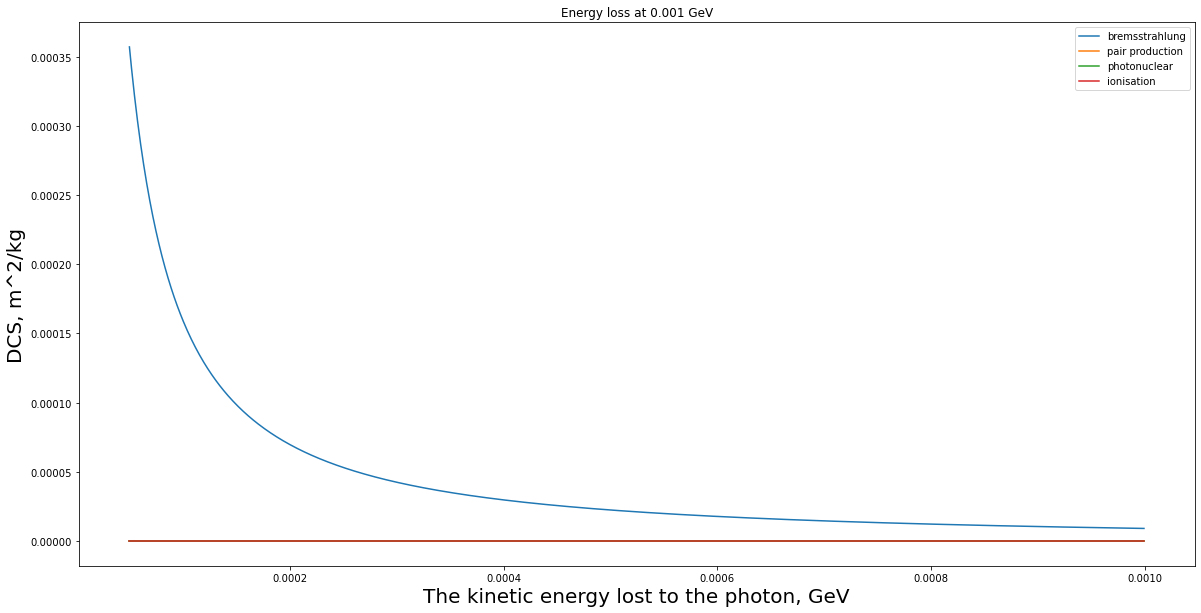

In [17]:
plot_recoil_energy(1e-3)

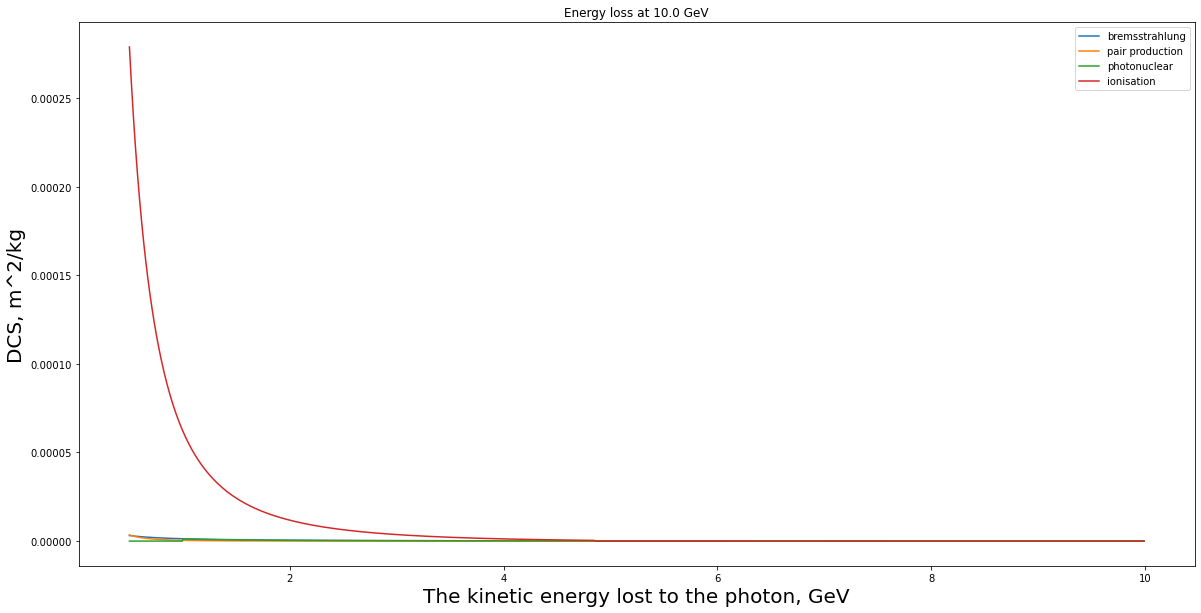

In [18]:
plot_recoil_energy(10.0)

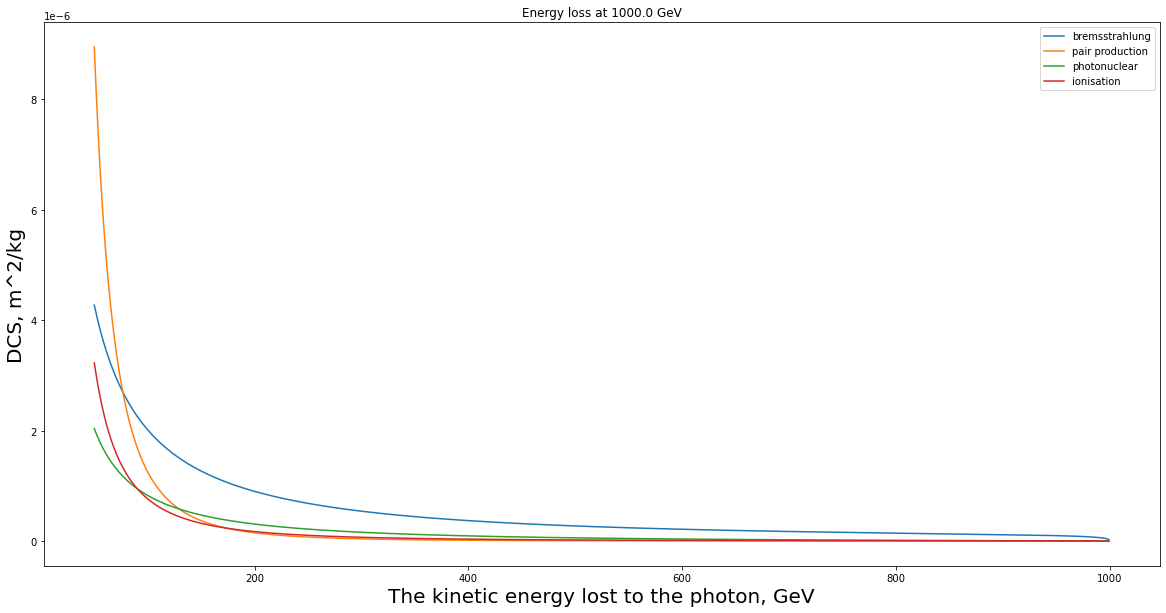

In [19]:
plot_recoil_energy(1e3)

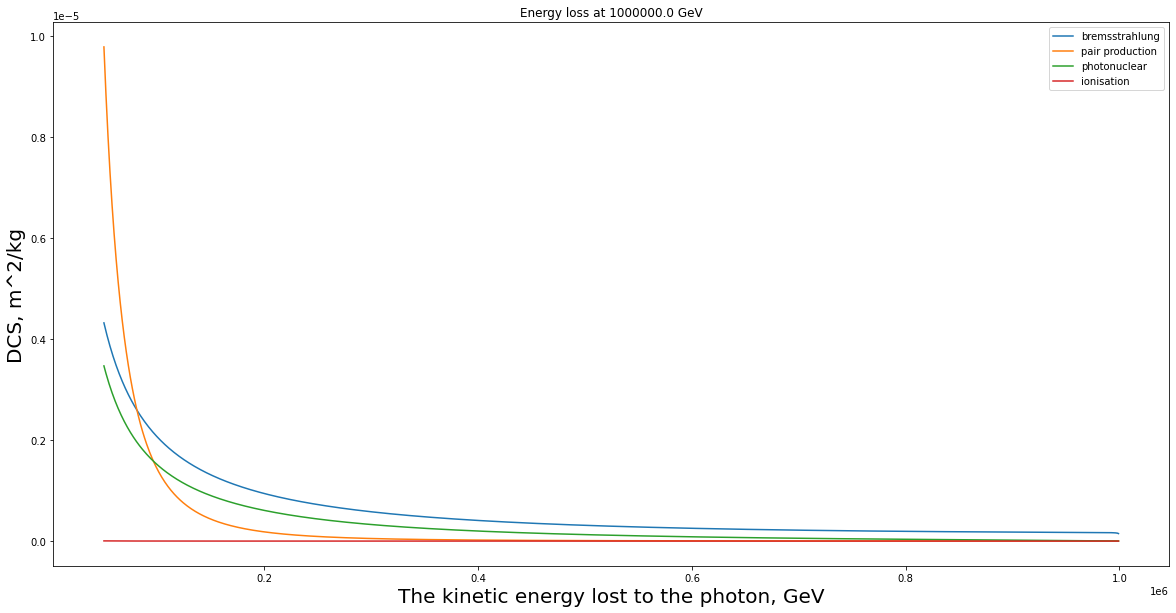

In [20]:
plot_recoil_energy(1e6)

### Modelling high energy DCS

An interpolation model in $\tau = q/K$ is used for $K \geq 10$ GeV. For Bremsstrahlung we re-write:

\begin{equation}
\frac{K}{E} \frac{\text{d}\sigma}{\text{d}q} = \frac{K \alpha Z}{q}(2\frac{m_e}{m_\mu})^{2}(\frac{4}{3}(1 - \nu) + \nu^2)(\Phi_\text{in}(\delta) + Z\Phi_n(\delta) ) \frac{N_a}{A \cdot 10^{-3}}
\end{equation}

Setting $X=\ln(\tau)$ and $Y=\ln(1-\tau)$, we fit the model:
\begin{equation}
\ln \left( \frac{K}{E} \frac{\text{d}\sigma}{\text{d}q} \right) \approx \sum_{i=0}^{6} a_i X^i + b_1 Y + b_2 Y^2
\end{equation}

